# Load Data

In [23]:
from pathlib import Path
import polars as pl
import datetime as dt
import matplotlib.pyplot as plt
import draw
import math

DATA_ROOT = './data'

def csv_to_df(filename: str, dtype: dict = None, pdates: bool = True, sep: str = ',') -> pl.LazyFrame:
    return pl.read_csv(Path(DATA_ROOT, filename), 
                       try_parse_dates=pdates, 
                       truncate_ragged_lines=True, 
                       infer_schema_length=None, 
                       schema_overrides=dtype,
                       separator=sep).lazy()

In [2]:
TEAMS = csv_to_df('teams.csv', sep=';')
SHIFTS = csv_to_df('shifts.csv')
ROSTERS = csv_to_df('rosters.csv')
PLAYS = csv_to_df('plays.csv', {'situationCode': pl.String})
PLAY_DETAILS = csv_to_df('play_details.csv')
GAMES = csv_to_df('games.csv', pdates=True)

In [3]:
COMBINED_PLAYS = PLAYS.join(PLAY_DETAILS, on=['gameId', 'eventId']).join(GAMES.select(['id', 'homeTeamId', 'awayTeamId', 'gameType', 'season']), left_on='gameId', right_on="id")

In [4]:
SHOTTYPES = PLAY_DETAILS.select(['shotType']).unique().with_columns(
    shotTypeId=pl.col('shotType').cum_count()
)
SHOTTYPES.collect()

shotType,shotTypeId
str,u32
"""wrist""",1
"""deflected""",2
"""tip-in""",3
"""snap""",4
"""between-legs""",5
…,…
"""wrap-around""",7
"""bat""",8
"""slap""",9


In [5]:
# setting up some constants
SHOT_CAT_DESC_KEY = ['shot-on-goal', 'blocked-shot', 'missed-shot', 'goal']
SHOOTOUT_SITUATION_CODE = ["1010", "0101"]
REGPERIOD_SEC = 20 * 60
PLAYOFFS_OT_SEC = 20 * 60
REGSEAZN_OT_SEC = 5 * 60
RUSH_WINDOW_SEC = 4
REBOUND_WINDOW_SEC = 4
ABS_NET_POS_X = 100 - 11

# Data tables

In [16]:
TEAMS.collect().shape, TEAMS.head(1).collect()

((32, 9),
 shape: (1, 9)
 ┌────────┬───────┬────────┬───────────┬───┬────────────────────┬─────────┬─────────┬───────────────┐
 │ teamid ┆ name  ┆ abbrev ┆ placename ┆ … ┆ darklogo           ┆ color1  ┆ color2  ┆ fullname      │
 │ ---    ┆ ---   ┆ ---    ┆ ---       ┆   ┆ ---                ┆ ---     ┆ ---     ┆ ---           │
 │ i64    ┆ str   ┆ str    ┆ str       ┆   ┆ str                ┆ str     ┆ str     ┆ str           │
 ╞════════╪═══════╪════════╪═══════════╪═══╪════════════════════╪═════════╪═════════╪═══════════════╡
 │ 24     ┆ Ducks ┆ ANA    ┆ Anaheim   ┆ … ┆ https://assets.nhl ┆ #00004E ┆ #FFB81C ┆ Anaheim Ducks │
 │        ┆       ┆        ┆           ┆   ┆ e.com/logos/…      ┆         ┆         ┆               │
 └────────┴───────┴────────┴───────────┴───┴────────────────────┴─────────┴─────────┴───────────────┘)

In [17]:
SHIFTS.collect().shape, SHIFTS.head(1).collect()

((1851750, 13),
 shape: (1, 13)
 ┌──────────┬────────────┬──────────┬──────────┬───┬────────────┬──────────┬────────┬──────────┐
 │ id       ┆ detailCode ┆ duration ┆ playerId ┆ … ┆ gameId     ┆ hexValue ┆ teamId ┆ typeCode │
 │ ---      ┆ ---        ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---      ┆ ---    ┆ ---      │
 │ i64      ┆ i64        ┆ str      ┆ i64      ┆   ┆ i64        ┆ str      ┆ i64    ┆ i64      │
 ╞══════════╪════════════╪══════════╪══════════╪═══╪════════════╪══════════╪════════╪══════════╡
 │ 12438645 ┆ 0          ┆ 01:01    ┆ 8471699  ┆ … ┆ 2022020365 ┆ #6F263D  ┆ 21     ┆ 517      │
 └──────────┴────────────┴──────────┴──────────┴───┴────────────┴──────────┴────────┴──────────┘)

In [63]:
PLAYS.collect().shape, PLAYS.head(1).collect()

((767648, 10),
 shape: (1, 10)
 ┌────────────┬─────────┬────────┬────────────┬───┬──────────┬─────────────┬───────────┬────────────┐
 │ gameId     ┆ eventId ┆ period ┆ periodType ┆ … ┆ typeCode ┆ typeDescKey ┆ sortOrder ┆ homeTeamDe │
 │ ---        ┆ ---     ┆ ---    ┆ ---        ┆   ┆ ---      ┆ ---         ┆ ---       ┆ fendingSid │
 │ i64        ┆ i64     ┆ i64    ┆ str        ┆   ┆ i64      ┆ str         ┆ i64       ┆ e          │
 │            ┆         ┆        ┆            ┆   ┆          ┆             ┆           ┆ ---        │
 │            ┆         ┆        ┆            ┆   ┆          ┆             ┆           ┆ str        │
 ╞════════════╪═════════╪════════╪════════════╪═══╪══════════╪═════════════╪═══════════╪════════════╡
 │ 2022020365 ┆ 51      ┆ 1      ┆ REG        ┆ … ┆ 520      ┆ period-star ┆ 8         ┆ left       │
 │            ┆         ┆        ┆            ┆   ┆          ┆ t           ┆           ┆            │
 └────────────┴─────────┴────────┴────────────┴───┴

In [19]:
PLAY_DETAILS.collect().shape, PLAY_DETAILS.head(1).collect()

((767648, 37),
 shape: (1, 37)
 ┌────────────┬─────────┬──────────────┬─────────────┬───┬─────────────┬────────┬────────┬──────────┐
 │ gameId     ┆ eventId ┆ assist1Playe ┆ assist1Play ┆ … ┆ winningPlay ┆ xCoord ┆ yCoord ┆ zoneCode │
 │ ---        ┆ ---     ┆ rId          ┆ erTotal     ┆   ┆ erId        ┆ ---    ┆ ---    ┆ ---      │
 │ i64        ┆ i64     ┆ ---          ┆ ---         ┆   ┆ ---         ┆ i64    ┆ i64    ┆ str      │
 │            ┆         ┆ i64          ┆ i64         ┆   ┆ i64         ┆        ┆        ┆          │
 ╞════════════╪═════════╪══════════════╪═════════════╪═══╪═════════════╪════════╪════════╪══════════╡
 │ 2022020365 ┆ 51      ┆ null         ┆ null        ┆ … ┆ null        ┆ null   ┆ null   ┆ null     │
 └────────────┴─────────┴──────────────┴─────────────┴───┴─────────────┴────────┴────────┴──────────┘)

In [20]:
ROSTERS.collect().shape, ROSTERS.head(1).collect()

((97052, 6),
 shape: (1, 6)
 ┌────────┬──────────┬───────────────┬──────────────┬─────────────────────────────────┬────────────┐
 │ teamId ┆ playerId ┆ sweaterNumber ┆ positionCode ┆ headshot                        ┆ gameId     │
 │ ---    ┆ ---      ┆ ---           ┆ ---          ┆ ---                             ┆ ---        │
 │ i64    ┆ i64      ┆ i64           ┆ str          ┆ str                             ┆ i64        │
 ╞════════╪══════════╪═══════════════╪══════════════╪═════════════════════════════════╪════════════╡
 │ 7      ┆ 8467950  ┆ 41            ┆ G            ┆ https://assets.nhle.com/mugs/n… ┆ 2022020365 │
 └────────┴──────────┴───────────────┴──────────────┴─────────────────────────────────┴────────────┘)

In [21]:
GAMES.collect().shape, GAMES.head(1).collect()

((2427, 7),
 shape: (1, 7)
 ┌────────────┬──────────┬──────────┬──────────────┬──────────────────┬────────────┬────────────┐
 │ id         ┆ season   ┆ gameType ┆ startTimeUTC ┆ venueTimezone    ┆ awayTeamId ┆ homeTeamId │
 │ ---        ┆ ---      ┆ ---      ┆ ---          ┆ ---              ┆ ---        ┆ ---        │
 │ i64        ┆ i64      ┆ i64      ┆ datetime[μs, ┆ str              ┆ i64        ┆ i64        │
 │            ┆          ┆          ┆ UTC]         ┆                  ┆            ┆            │
 ╞════════════╪══════════╪══════════╪══════════════╪══════════════════╪════════════╪════════════╡
 │ 2022020365 ┆ 20222023 ┆ 2        ┆ 2022-12-02   ┆ America/New_York ┆ 21         ┆ 7          │
 │            ┆          ┆          ┆ 00:00:00 UTC ┆                  ┆            ┆            │
 └────────────┴──────────┴──────────┴──────────────┴──────────────────┴────────────┴────────────┘)

In [35]:
COMBINED_PLAYS.head(1).collect()

gameId,eventId,period,periodType,timeInPeriod,situationCode,typeCode,typeDescKey,sortOrder,homeTeamDefendingSide,assist1PlayerId,assist1PlayerTotal,assist2PlayerId,assist2PlayerTotal,awaySOG,awayScore,blockingPlayerId,committedByPlayerId,descKey,discreteClip,drawnByPlayerId,duration,eventOwnerTeamId,goalieInNetId,highlightClip,highlightClipFr,highlightClipSharingUrl,highlightClipSharingUrlFr,hitteePlayerId,hittingPlayerId,homeSOG,homeScore,losingPlayerId,playerId,reason,scoringPlayerId,scoringPlayerTotal,secondaryReason,shootingPlayerId,shotType,typeCode_right,winningPlayerId,xCoord,yCoord,zoneCode,homeTeamId,awayTeamId,gameType
i64,i64,i64,str,str,i64,i64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,str,str,i64,i64,i64,str,i64,i64,i64
2022020365,51,1,"""REG""","""00:00""",1551,520,"""period-start""",8,"""left""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7,21,2


### Investigating Net location mapping

Seems like the `homeTeamDefendingSide` isn't very reliable as an indicator of location mapping, and 
possibly zodeCode too

In [ ]:
COMBINED_PLAYS.collect()('homeTeamDefendingSide').value_counts()

homeTeamDefendingSide,count
str,u32
"""right""",392658
"""left""",374990


In [27]:
(
    COMBINED_PLAYS
    .filter(pl.col('xCoord').is_not_null())
    .with_columns(
        isHomeEvent=pl.col('eventOwnerTeamId') == pl.col('homeTeamId'),
        # assume consistently left means net.xcoord > 0, right means net.xcoord < 0
        homeTeamNetX=pl.when(pl.col('homeTeamDefendingSide') == pl.lit('left')).then(pl.lit(100)).otherwise(pl.lit(-100)),
        awayTeamNetX=pl.when(pl.col('homeTeamDefendingSide') == pl.lit('left')).then(pl.lit(-100)).otherwise(pl.lit(100)),
    )
    .with_columns(
        netX=pl.when(pl.col('isHomeEvent')).then(pl.col('homeTeamNetX')).otherwise(pl.col('awayTeamNetX')),
        isHomeEventId=pl.when(pl.col('isHomeEvent')).then(pl.lit(1)).otherwise(pl.lit(-1)),
    )
    .with_columns(isConsistent=pl.col('isHomeEventId').mul(pl.col('netX')).mul('xCoord') >= 0)
    .select([
        'xCoord', 'isHomeEvent', 'netX', 'typeDescKey',
        'zoneCode', 'isConsistent',
        # 'homeTeamNetX', 'awayTeamNetX', 
    ])
    .filter(pl.col('isConsistent'))
    .collect()
)

xCoord,isHomeEvent,netX,typeDescKey,zoneCode,isConsistent
i64,bool,i32,str,str,bool
0,true,100,"""faceoff""","""N""",true
47,true,100,"""shot-on-goal""","""O""",true
74,true,100,"""blocked-shot""","""D""",true
76,true,100,"""missed-shot""","""O""",true
98,false,-100,"""hit""","""D""",true
…,…,…,…,…,…
2,true,100,"""shot-on-goal""","""N""",true
5,false,-100,"""giveaway""","""N""",true
20,true,100,"""faceoff""","""N""",true


In [28]:
(
    COMBINED_PLAYS
    .filter(pl.col('xCoord').is_not_null())
    .filter(pl.col('zoneCode').is_in(['O', 'D']))
    .join(GAMES, left_on="gameId", right_on="id")
    .with_columns(
        isHomeEventInt=pl.when(pl.col('eventOwnerTeamId') == pl.col('homeTeamId')).then(1).otherwise(-1),
        isOffense=pl.when(pl.col('zoneCode') == pl.lit('O')).then(1).otherwise(-1),
    )
    .with_columns(
        isConsistent=pl.col('isHomeEventInt').mul(pl.col('isOffense')).mul(pl.col('xCoord')) > 0
    )
    # .with_columns(isConsistent=pl.col('isHomeEventId').mul(pl.col('netX')).mul('xCoord') >= 0)
    .select([
        'typeDescKey', 'isHomeEventInt', 'isOffense', 
        'xCoord', 'zoneCode', 'isConsistent',
        # 'homeTeamNetX', 'awayTeamNetX', 
    ])
    .filter(pl.col('isConsistent').not_())
    .collect()
)

typeDescKey,isHomeEventInt,isOffense,xCoord,zoneCode,isConsistent
str,i32,i32,i64,str,bool
"""blocked-shot""",1,-1,74,"""D""",false
"""blocked-shot""",1,-1,74,"""D""",false
"""blocked-shot""",1,-1,58,"""D""",false
"""blocked-shot""",-1,-1,-69,"""D""",false
"""blocked-shot""",-1,-1,-72,"""D""",false
…,…,…,…,…,…
"""blocked-shot""",1,-1,72,"""D""",false
"""blocked-shot""",-1,-1,-83,"""D""",false
"""blocked-shot""",1,-1,57,"""D""",false


### Checking penalty shot situationCode

In [10]:
(
    COMBINED_PLAYS
    .filter(pl.col('situationCode').is_in(SHOOTOUT_SITUATION_CODE).and_(pl.col('period') <= 3))
    .select('typeDescKey')
    .collect()['typeDescKey']
    .value_counts()
)

typeDescKey,count
str,u32
"""goal""",28
"""failed-shot-attempt""",5
"""shot-on-goal""",45
"""missed-shot""",9


# Transforming Data

## Feature engineering

- doesn't do too well with too many parameters
- first attempt at a basic model

Features to use:

| feature | description | is parameter |
| ------- | ----------- | ------------ |
| `typeDescKey` | event desc | y |
| `sortOrder` | canonical order of events | n |
| `period` | periodId | y |
| `periodType` | REG / OT (filter out SO) | n |
| `eventOwnerTeamId` | event owner team id | y |
| `xCoord` | rink xcoords (N/S) | n |
| `yCoord` | rink ycoords (E/W) | n |

Features to add:

| feature | description | is parameter | added | 
| ------- | ----------- | ------------ | ----- |
| `deltaTime` | time since last event (any) | n | y | 
| `deltaTimeHomeShot` | time since last home shot | n | y |
| `deltaTimeHomeShot` | time since last away shot | n | y |
| `deltaDist` | distance since last event (any) | n | y |
| `distFromNet` | distance from owner team's net | n | y |
| `shotAngle` | angle of shot from center North/South line | n | y |
| `deltaAngle` | change in angle since last shot | n | y |
| `rebound` | 0 / 1 (last shot by same team within 4 seconds) | n | y |
| `rush` | 0 / 1 (last shot by diff team from opposite end within 4 seconds) | n | y |
| `goal` | 0 / 1 | n | y |
| `shot` | 0 / 1 | n | y |
| `block` | 0 / 1 | n | y |
| `miss` | 0 / 1 | n | y |
| `isHome` | True / False | n | y |
| `homeGf` | cumsum | n | y |
| `homeSog` | cumsum | n | y |
| `homeBlocked` | cumsum | n | y |
| `homeMiss` | cumsum | n | y |
| `homeCf` |  shots + blocks + misses | y | y |
| `homeFf` |  shots + misses | y | y |
| `awayGf` | cumsum | n | y |
| `awaySog` | cumsum | n | y |
| `awayBlocked` | cumsum | n | y |
| `awayMiss` | cumsum | n | y |
| `awayCf` |  shots + blocks + misses | y | y |
| `awayFf` |  shots + misses | y | y |
| `gDiff` | homeGoal - awayGoal | n |  |
| `homeSkt` | home num of skaters | n | y |
| `homeEn` | invert `homeGoalie` | y | y |
| `awaySkt` | away num of skaters | n | y |
| `awayEn` | invert `awayGoalie` | y | y |
| `otLengthSec` | if gametype is 2, then `5 * 60`, else `20 * 60` | n | y |
| `timeInPeriodSec` | computed time from start of period | y | y |
| `timeSinceStartSec` | computed time from start of game | n | y |

In [6]:
def time_to_seconds_expr(label: str):
    dt_expr = (
        pl.col(label)
        .str.to_datetime("%H:%M")
    )
    return dt_expr.dt.hour().cast(pl.Int64) * 60 + dt_expr.dt.minute().cast(pl.Int64)

def is_event_by(home_or_away: str):
    return pl.col(f"{home_or_away}TeamId") == pl.col("eventOwnerTeamId")

def dist_from_xy_now(lastX: str, lastY: str):
    return ((pl.col(lastX) - pl.col('xCoord')).pow(2) + (pl.col(lastY) - pl.col('yCoord')).pow(2)).pow(0.5)

pl.Config().set_tbl_rows(100);

### Calculating home/away net position

Since neither the `zoneCode` nor `homeTeamDefendingSide` are consistent, we will take Team A's net location as the side the opposing team B shoots more at.

In [7]:
NET_LOCATION_ESTIMATE = (
    COMBINED_PLAYS
    # remove shootouts AND penalty shots
    .filter(pl.col('situationCode').is_in(SHOOTOUT_SITUATION_CODE).not_())
    # sort by gameId and sortOrder
    .sort('sortOrder', descending=False)
    .sort('gameId', descending=False)
    .with_columns(
        goal=pl.when(pl.col('typeDescKey') == 'goal').then(1).otherwise(0),
        shot=pl.when(pl.col('typeDescKey').is_in(SHOT_CAT_DESC_KEY)).then(1).otherwise(0),
    )
    .with_columns(
        homeNetPosXBias=pl.when(pl.col('shot') == 1).then(
            # we're going to determine the position of the home team's net by the majority of where the shots are attempted
            pl.when((is_event_by('away').and_(pl.col('xCoord') > 0)).or_(is_event_by('home').and_(pl.col('xCoord') < 0))).then(1).otherwise(-1)
        ).otherwise(0),
    )
    .with_columns(
        homeNetPosXBias=pl.col('homeNetPosXBias').cum_sum().over(['gameId', 'period'])
    )
    .with_columns(
        homeNetXCoordEst=pl.when(pl.col('homeNetPosXBias') > 0).then(ABS_NET_POS_X).otherwise(-ABS_NET_POS_X),
        awayNetXCoordEst=pl.when(pl.col('homeNetPosXBias') > 0).then(-ABS_NET_POS_X).otherwise(ABS_NET_POS_X),
    )
    .select([
        'gameId', 'period', 'homeNetXCoordEst', 'awayNetXCoordEst', 
        # 'homeNetPosXBias',
        # 'sortOrder', 'typeDescKey'
    ])
    .group_by('gameId', 'period')
    .last()
)
NET_LOCATION_ESTIMATE.collect().sort('period', descending=False).sort('gameId', descending=False).head(10)

gameId,period,homeNetXCoordEst,awayNetXCoordEst
i64,i64,i32,i32
2022020320,1,-89,89
2022020320,2,89,-89
2022020320,3,-89,89
2022020338,1,-89,89
2022020338,2,89,-89
2022020338,3,-89,89
2022020365,1,-89,89
2022020365,2,89,-89
2022020365,3,-89,89


In [8]:
plays = (
    COMBINED_PLAYS
    # remove shootouts AND penalty shots
    .filter(pl.col('situationCode').is_in(SHOOTOUT_SITUATION_CODE).not_())
    # sort by gameId and sortOrder
    .sort('sortOrder', descending=False)
    .sort('gameId', descending=False)
    # join the 
    .join(NET_LOCATION_ESTIMATE, on=['gameId', 'period'])
    .with_columns(
        eventBy=pl.when(is_event_by('home')).then(pl.lit('home')).otherwise(pl.lit('away')),
        goal=pl.when(pl.col('typeDescKey') == 'goal').then(1).otherwise(0),
        shot=pl.when(pl.col('typeDescKey').is_in(SHOT_CAT_DESC_KEY)).then(1).otherwise(0),
        block=pl.when(pl.col('typeDescKey') == 'blocked-shot').then(1).otherwise(0),
        miss=pl.when(pl.col('typeDescKey') == 'missed-shot').then(1).otherwise(0),
        homeEn=pl.col('situationCode').str.starts_with(0),
        awayEn=pl.col('situationCode').str.ends_with(0),
        homeSkt=pl.col('situationCode').str.slice(2,1).str.to_integer(),
        awaySkt=pl.col('situationCode').str.slice(1,1).str.to_integer(),
        timeRemainingSec=time_to_seconds_expr('timeRemaining'),
        numOtPeriods=pl.max_horizontal(pl.lit(0), pl.col('period') - 3),
        numRegPeriods=pl.min_horizontal(pl.lit(3), pl.col('period')),
        otLengthSec=pl.when(pl.col('gameType') == 3).then(PLAYOFFS_OT_SEC).otherwise(REGSEAZN_OT_SEC),
    )
    .with_columns(
        timeSinceStartSec=pl.col('numRegPeriods') * pl.lit(REGPERIOD_SEC) + pl.col('numOtPeriods') * pl.col('otLengthSec') - pl.col('timeRemainingSec'),
        goalByTeamId=pl.when(pl.col('goal') == 1).then(pl.when(is_event_by('home')).then(pl.col('homeTeamId')).otherwise(pl.col('awayTeamId'))).otherwise(None),
        shotByTeamId=pl.when(pl.col('shot') == 1).then(pl.when(is_event_by('home')).then(pl.col('homeTeamId')).otherwise(pl.col('awayTeamId'))).otherwise(None),
        netShotAtXCoord=pl.when(pl.col('shot') == 1).then(pl.when(is_event_by('home')).then(pl.col('awayNetXCoordEst')).otherwise(pl.col('homeNetXCoordEst'))).otherwise(None),
    )
    .with_columns(
        angDeg=pl.when(pl.col('shot') == 1).then(
            (pl.col('yCoord').abs() / (pl.col('xCoord') - pl.col('netShotAtXCoord')).abs()).arctan() / math.pi * 180.0
        ).otherwise(None),
        distFromNet=((pl.col('xCoord') - pl.col('netShotAtXCoord')).pow(2) + pl.col('yCoord').pow(2)).pow(0.5),
    )
    # per game
    .with_columns(
        homeGf=pl.when((pl.col('goal') == 1).and_(is_event_by('home'))).then(1).otherwise(0),
        awayGf=pl.when((pl.col('goal') == 1).and_(is_event_by('away'))).then(1).otherwise(0),
        # Corsi Fors
        homeCf=pl.when((pl.col('shot') == 1).and_(is_event_by('home'))).then(1).otherwise(0),
        awayCf=pl.when((pl.col('shot') == 1).and_(is_event_by('away'))).then(1).otherwise(0),
        homeBlocked=pl.when((pl.col('block') == 1).and_(is_event_by('home'))).then(1).otherwise(0),
        awayBlocked=pl.when((pl.col('block') == 1).and_(is_event_by('away'))).then(1).otherwise(0),
        homeMiss=pl.when((pl.col('miss') == 1).and_(is_event_by('home'))).then(1).otherwise(0),
        awayMiss=pl.when((pl.col('miss') == 1).and_(is_event_by('away'))).then(1).otherwise(0),
    )
    .with_columns(
        homeGf=pl.col('homeGf').cum_sum().over(['gameId']),
        awayGf=pl.col('awayGf').cum_sum().over(['gameId']),
        homeCf=pl.col('homeCf').cum_sum().over(['gameId']),
        awayCf=pl.col('awayCf').cum_sum().over(['gameId']),
        homeBlocked=pl.col('homeBlocked').cum_sum().over(['gameId']),
        awayBlocked=pl.col('awayBlocked').cum_sum().over(['gameId']),
        homeMiss=pl.col('homeMiss').cum_sum().over(['gameId']),
        awayMiss=pl.col('awayMiss').cum_sum().over(['gameId']),
    )
    .with_columns(
        homeSog=pl.col('homeCf') - pl.col('homeBlocked') - pl.col('homeMiss'),
        awaySog=pl.col('awayCf') - pl.col('awayBlocked') - pl.col('awayMiss'),
        # Fenwick Fors
        homeFf=pl.col('homeCf') - pl.col('homeBlocked'),
        awayFf=pl.col('awayCf') - pl.col('awayBlocked'),
    )
    # per period
    .with_columns(
        # for calculating rush
        lastXCoord=pl.col('xCoord').shift(1).over(['gameId', 'period']).fill_null(0),
        lastYCoord=pl.col('yCoord').shift(1).over(['gameId', 'period']).fill_null(0),
        # for calculating rebound angle
        lastHomeShotXCoord=pl.when(is_event_by('home').and_(pl.col('shot') == 1)).then(pl.col('xCoord')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        lastAwayShotXCoord=pl.when(is_event_by('away').and_(pl.col('shot') == 1)).then(pl.col('xCoord')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        lastHomeShotYCoord=pl.when(is_event_by('home').and_(pl.col('shot') == 1)).then(pl.col('yCoord')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        lastAwayShotYCoord=pl.when(is_event_by('away').and_(pl.col('shot') == 1)).then(pl.col('yCoord')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        lastHomeShotAngDeg=pl.when(is_event_by('home').and_(pl.col('shot') == 1)).then(pl.col('angDeg')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        lastAwayShotAngDeg=pl.when(is_event_by('away').and_(pl.col('shot') == 1)).then(pl.col('angDeg')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        # both rush and rebounds will need to look at time
        lastTimeRemainingSec=pl.col('timeRemainingSec').shift(1).over(['gameId', 'period']).fill_null(REGPERIOD_SEC),
        lastHomeShotTimeRemainingSec=pl.when(is_event_by('home').and_(pl.col('shot') == 1)).then(pl.col('timeRemainingSec')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
        lastAwayShotTimeRemainingSec=pl.when(is_event_by('away').and_(pl.col('shot') == 1)).then(pl.col('timeRemainingSec')).otherwise(None).forward_fill().shift(1).over(['gameId', 'period']),
    )
    .with_columns(
        deltaTime=pl.col('lastTimeRemainingSec') - pl.col('timeRemainingSec'),
        deltaTimeHomeShot=pl.col('lastHomeShotTimeRemainingSec') - pl.col('timeRemainingSec'),
        deltaTimeAwayShot=pl.col('lastAwayShotTimeRemainingSec') - pl.col('timeRemainingSec'),
        deltaAngDegHomeShot=pl.when(pl.col('angDeg').is_not_null()).then(pl.col('lastHomeShotAngDeg') - pl.col('angDeg')).otherwise(None),
        deltaAngDegAwayShot=pl.when(pl.col('angDeg').is_not_null()).then(pl.col('lastAwayShotAngDeg') - pl.col('angDeg')).otherwise(None),
        deltaXCoord=pl.col('lastXCoord') - pl.col('xCoord'),
        deltaYCoord=pl.col('lastYCoord') - pl.col('yCoord'),
    )
    .with_columns(
        deltaDist=dist_from_xy_now('lastXCoord', 'lastYCoord'),
        deltaDistShot=pl.when(is_event_by('home')).then(dist_from_xy_now('lastHomeShotXCoord', 'lastHomeShotYCoord')).otherwise(dist_from_xy_now('lastAwayShotXCoord', 'lastAwayShotYCoord')),
        deltaTimeShot=pl.max_horizontal(pl.when(is_event_by('home')).then(pl.col('deltaTimeHomeShot')).otherwise(pl.col('deltaTimeAwayShot')), pl.lit(0.0001)),
        rush=pl.when((pl.col('xCoord') * pl.col('lastXCoord') < 0).and_(pl.col('shot') == 1).and_(pl.col('deltaTime') < RUSH_WINDOW_SEC)).then(1).otherwise(0), # time since last event
        # time since last shot
        rebound=pl.when((pl.col('xCoord') * pl.col('lastXCoord') > 0).and_(pl.col('shot') == 1).and_((pl.col('deltaTimeHomeShot') < REBOUND_WINDOW_SEC).or_(pl.col('deltaTimeAwayShot') < REBOUND_WINDOW_SEC))).then(1).otherwise(0) 
    )
    .with_columns(
        shotDeltaDistOverDeltaTime=pl.col('deltaDistShot') / pl.col('deltaTimeShot')
    )
    # .filter(pl.col('gameType') == 2)
)
(
    plays
    .select(
        # "*"
        [ 
            'gameId', 'period', 'sortOrder', 'typeDescKey', 'eventBy','situationCode',
            "xCoord", "netShotAtXCoord", 'yCoord', 'shot', 'angDeg',
            'lastAwayShotAngDeg', 'lastHomeShotAngDeg',
            'deltaAngDegHomeShot', 'deltaAngDegAwayShot', 
            # 'goal', 'shot', 
            # 'situationCode', 'timeSinceStartSec', 'numOtPeriods', 'numRegPeriods', 'otLengthSec', 
            # 'homeEn', 'awayEn',
            # 'homeSkt', 'awaySkt',
            # 'homeGf', 'awayGf',
            # 'homeCf', 'awayCf',
            # 'homeFf', 'awayFf',
            # 'homeBlocked', 'awayBlocked',
            # 'homeMiss', 'awayMiss',
            # 'deltaTime', 'deltaTimeHomeShot', 'deltaTimeAwayShot', 'deltaDist',
            # 'rush', 'rebound', 'goalByTeamId', 'shotByTeamId',
            # 'lastHomeShotTimeRemainingSec',
            # 'lastAwayShotTimeRemainingSec',
            # 'lastHomeShotXCoord',
            # 'lastHomeShotYCoord',
            # 'lastAwayShotXCoord',
            # 'lastAwayShotYCoord',
        ]
    )
    # .filter(pl.col('deltaTimeHomeShot') < 0)
    # .filter(pl.col('rebound') == 1)
    # .filter(pl.col('shot') == 1)
    .head(10)
    .collect()
)

gameId,period,sortOrder,typeDescKey,eventBy,situationCode,xCoord,netShotAtXCoord,yCoord,shot,angDeg,lastAwayShotAngDeg,lastHomeShotAngDeg,deltaAngDegHomeShot,deltaAngDegAwayShot
i64,i64,i64,str,str,str,i64,i32,i64,i32,f64,f64,f64,f64,f64
2022020320,1,8,"""period-start""","""away""","""1551""",null,null,null,0,null,null,null,null,null
2022020320,1,11,"""faceoff""","""home""","""1551""",0,null,0,0,null,null,null,null,null
2022020320,1,12,"""hit""","""home""","""1551""",-97,null,9,0,null,null,null,null,null
2022020320,1,13,"""goal""","""away""","""1551""",-44,-89,-28,1,31.890792,null,null,null,null
2022020320,1,16,"""faceoff""","""away""","""1551""",0,null,0,0,null,31.890792,null,null,null
2022020320,1,17,"""giveaway""","""away""","""1551""",90,null,30,0,null,31.890792,null,null,null
2022020320,1,26,"""shot-on-goal""","""away""","""1551""",48,-89,35,1,14.331073,31.890792,null,null,17.559718
2022020320,1,35,"""stoppage""","""away""","""1551""",null,null,null,0,null,14.331073,null,null,null
2022020320,1,37,"""faceoff""","""home""","""1551""",69,null,-22,0,null,14.331073,null,null,null


# Exploration

In [63]:
team_id_abbrev = TEAMS.select(['teamid', 'abbrev', 'color1', 'color2']).lazy()

In [64]:
def draw_xy_shot(df: pl.DataFrame, title: str, ax = plt, c : pl.Series | str | None = None, filename: str | None = None):
    ax.scatter(df['xCoord'], df['yCoord'], c=c, s=2)
    if ax == plt:
        ax.xlim(draw.RINK[0])
        ax.ylim(draw.RINK[1])
        ax.gca().set_aspect('equal')
        ax.title(title)
    else:
        ax.set_xlim(draw.RINK[0])
        ax.set_ylim(draw.RINK[1])
        ax.set_aspect('equal')
        ax.set_title(title)
        
    if filename:
        ax.savefig(f'./diagrams/{filename}')

In [65]:
def draw_teams_goals(df: pl.LazyFrame, label: str, team_column_label: str):
    fig, axes = plt.subplots(8,4)

    teams = team_id_abbrev.collect().to_dicts()
    for idx, team in enumerate(teams):
        r = idx // 4
        c = idx % 4
        
        draw_xy_shot(
            df.filter(pl.col(team_column_label) == team['teamid']).collect(), 
            label % team['abbrev'],
            ax=axes[r, c],
            c=team['color1']
        )
    fig.set_figheight(20)
    fig.set_figwidth(30)
    return fig, axes

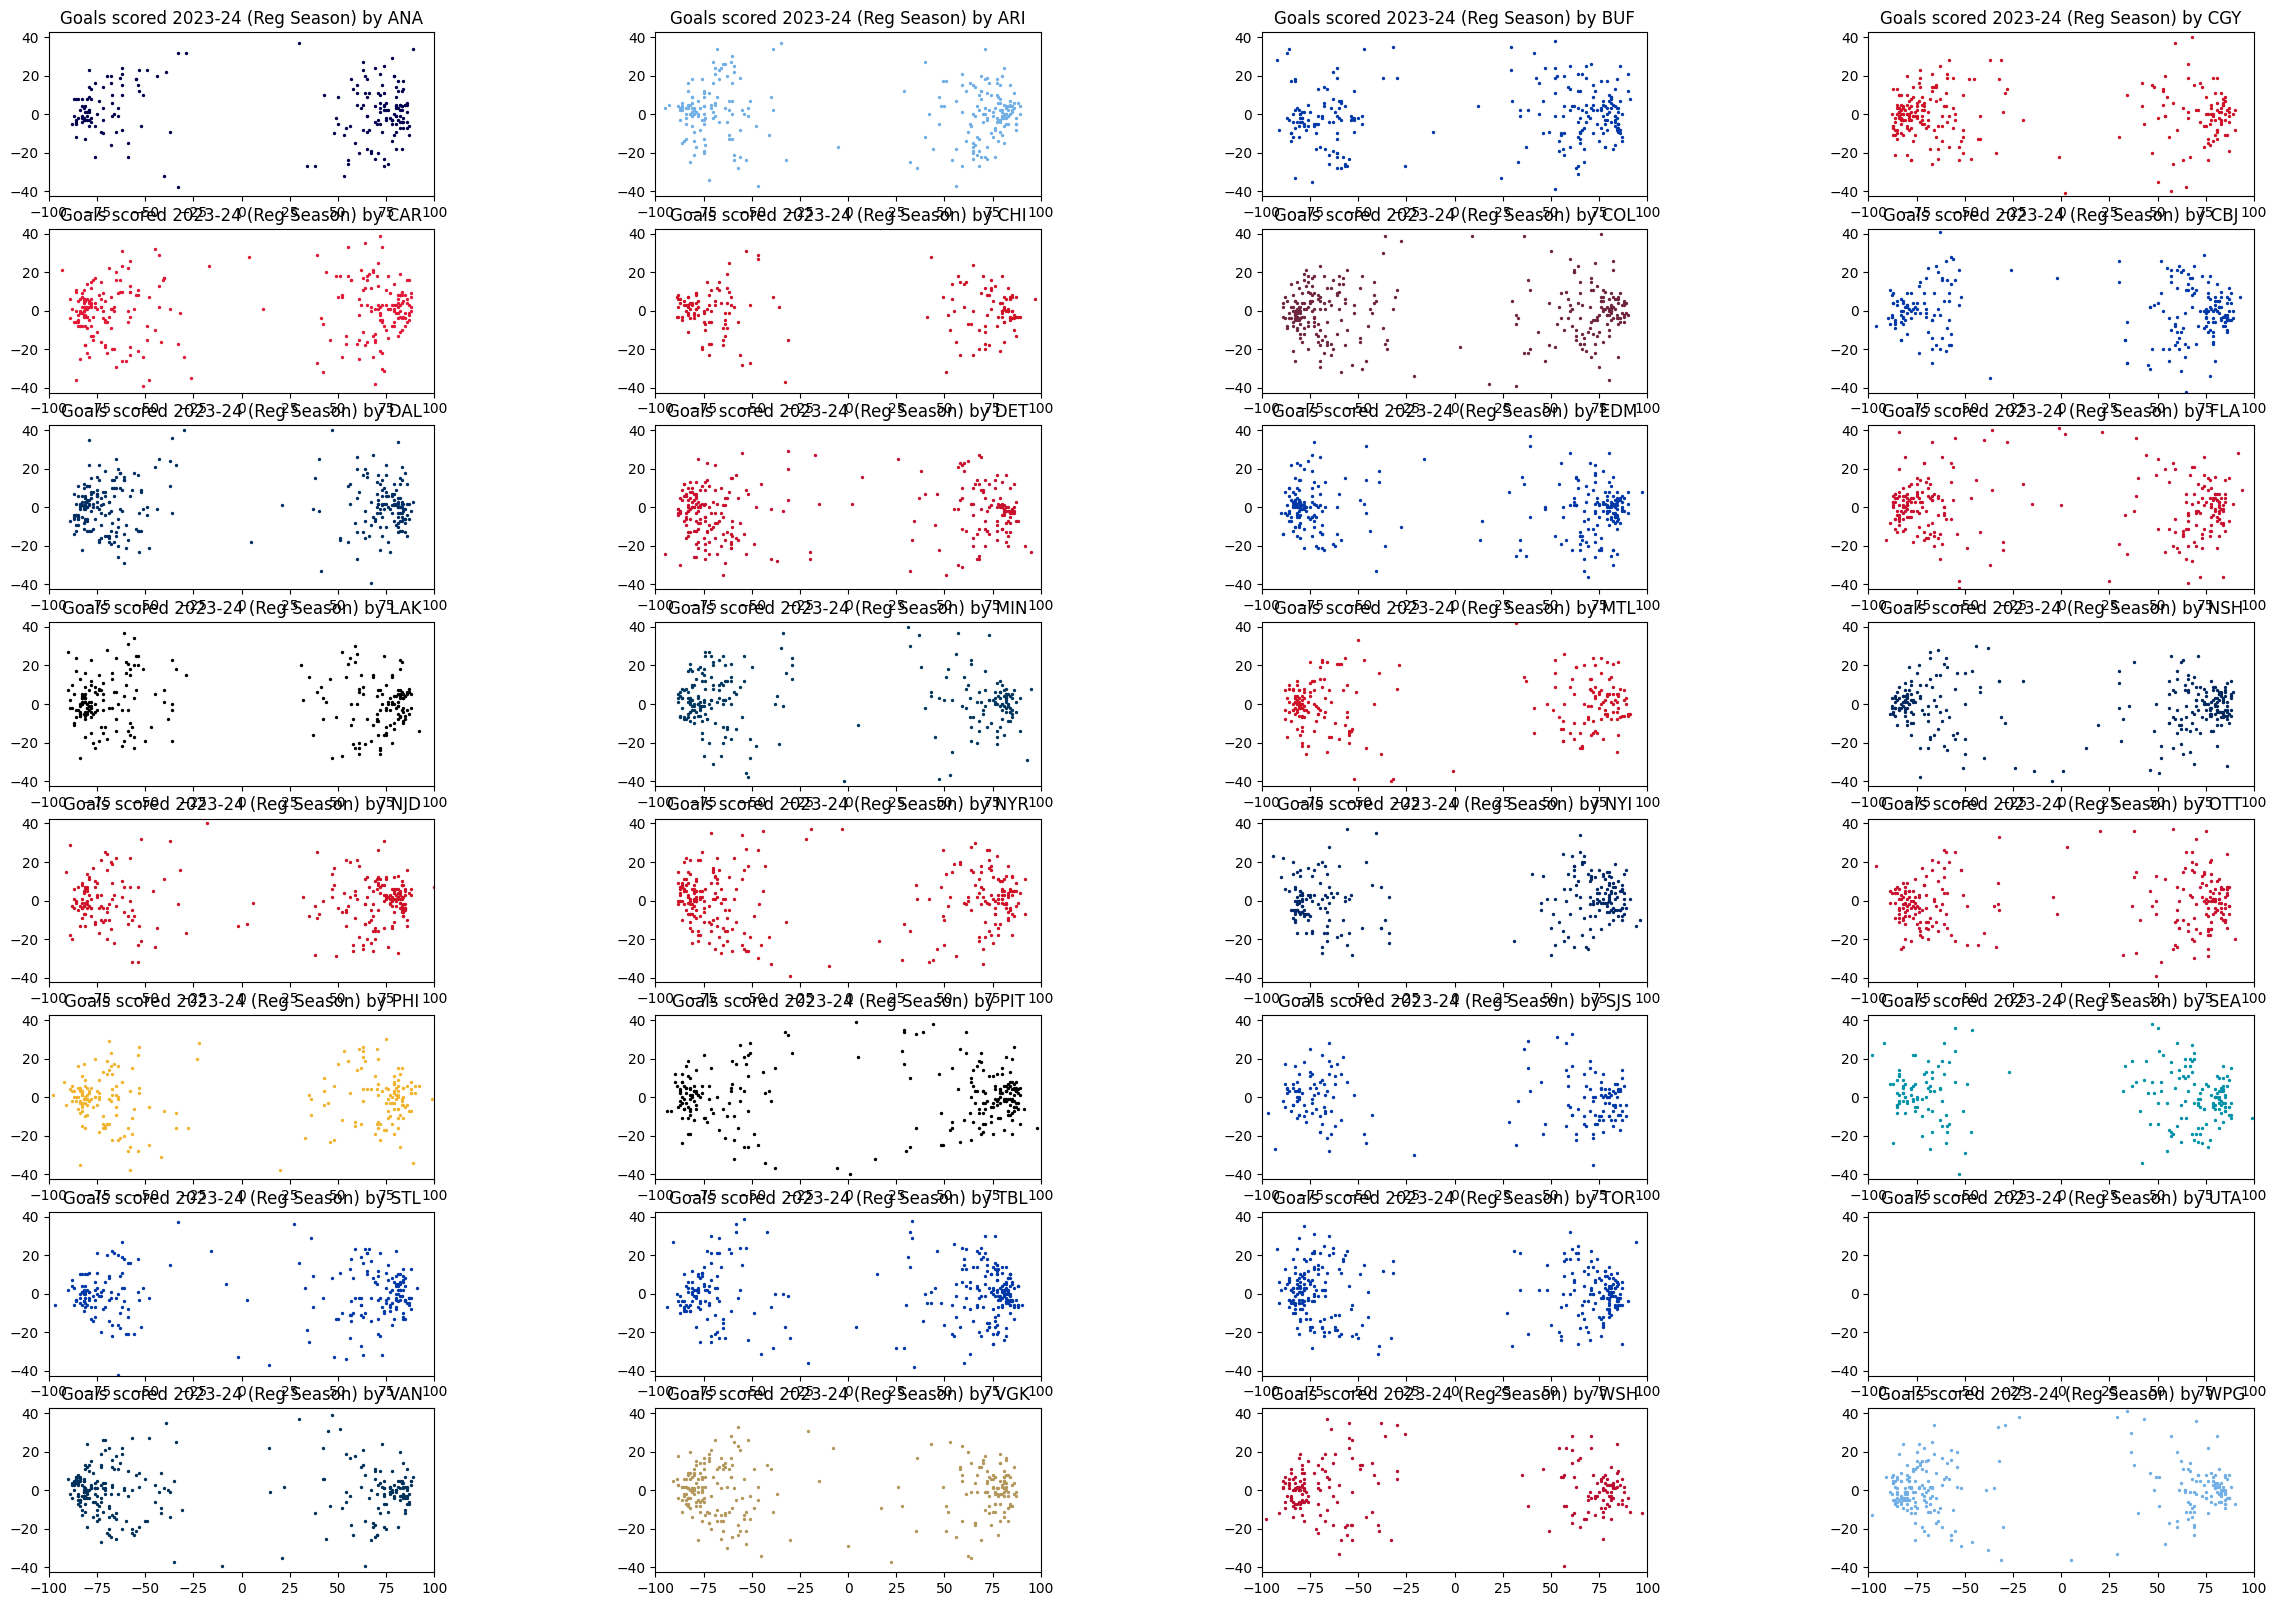

In [66]:
fig, axes = draw_teams_goals(
    plays.filter(pl.col('goal') == 1).filter(pl.col('season') == 20232024).filter(pl.col('gameType') == 2), 
    "Goals scored 2023-24 (Reg Season) by %s",
    'goalByTeamId'
)

#### Rush goals

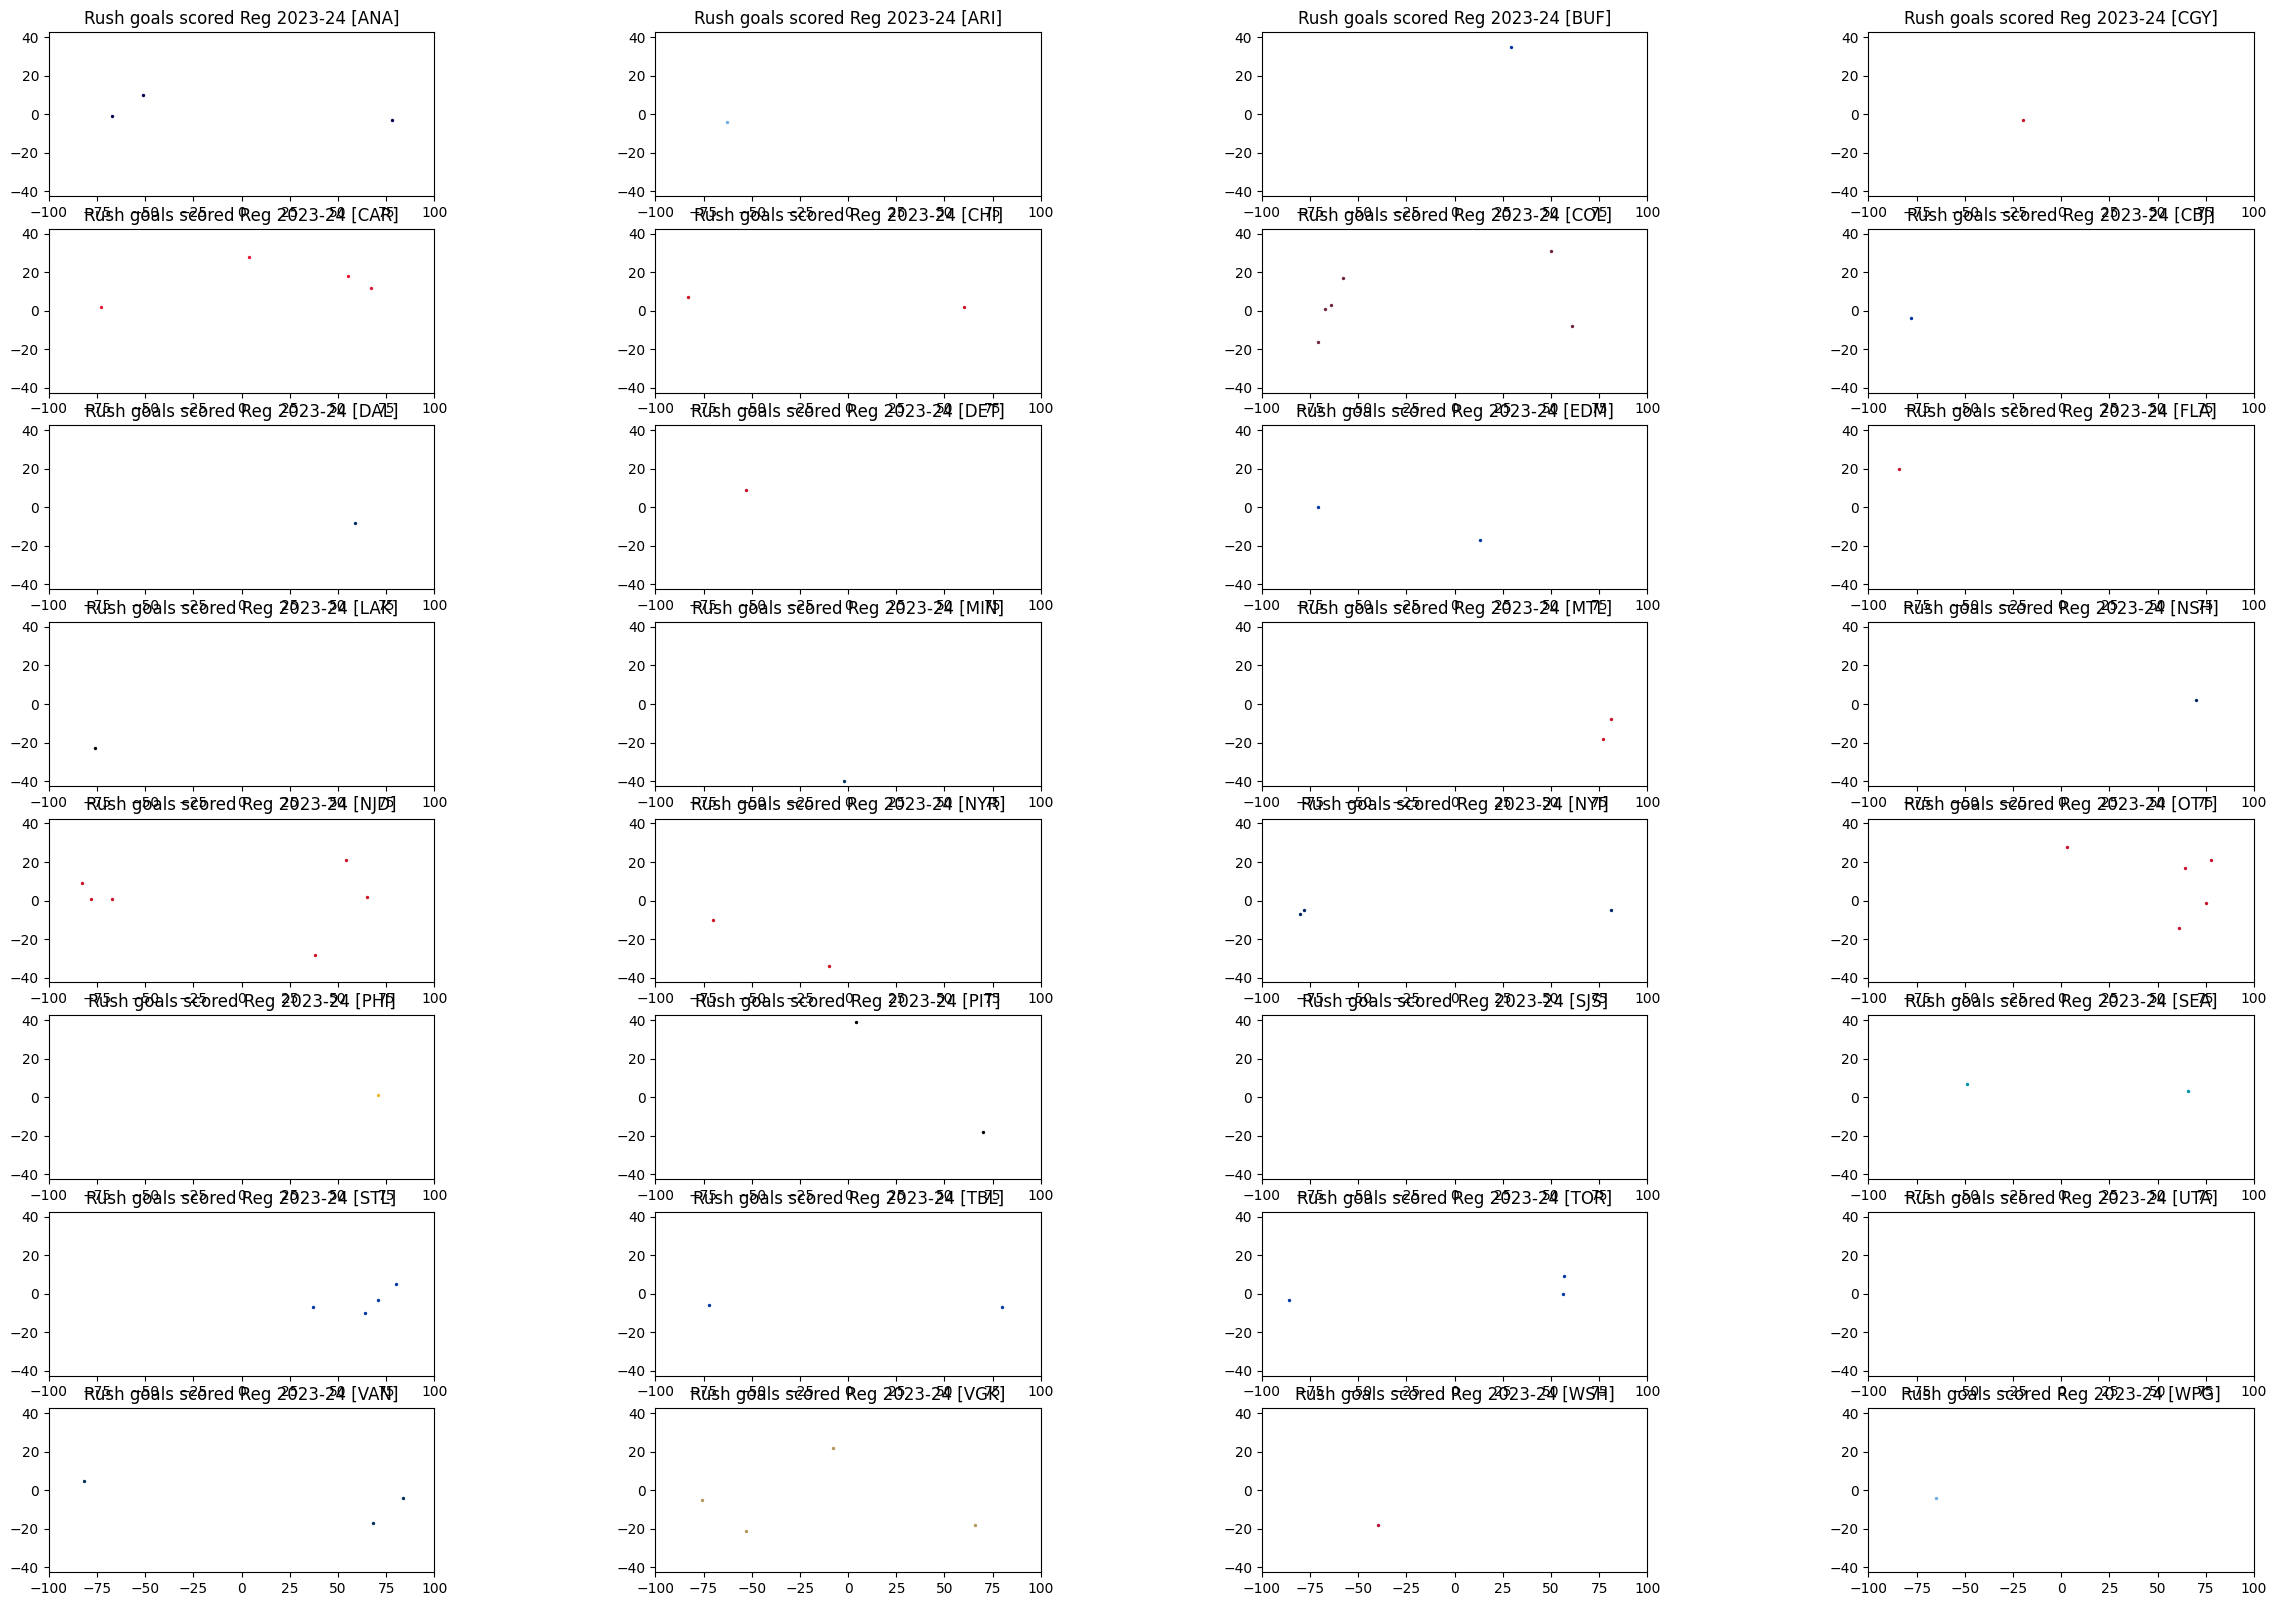

In [67]:
rush_all = (
    plays
    .filter(pl.col('rush') == 1)
    .filter(pl.col('season') == 20232024)
    .filter(pl.col('gameType') == 2)
)
fig, axes = draw_teams_goals(
    rush_all.filter(pl.col('shot') == 1),
    "Rush goals scored Reg 2023-24 [%s]",
    'goalByTeamId'
)

In [68]:
def get_counts_by_team(lf: pl.LazyFrame):
    return (
        lf.collect()['eventOwnerTeamId']
        .value_counts()
        .join(team_id_abbrev.collect(), left_on='eventOwnerTeamId', right_on='teamid', how='full')
        .sort('abbrev')
        .fill_null(0)
        .filter(pl.col('color1').is_not_null())
    )

rush_shots_by_team = get_counts_by_team(
    rush_all
    .with_columns(shotOnly=pl.col('shot') - pl.col('goal'))
    .filter(pl.col('shotOnly') == 1)
)
rush_goals_by_team = get_counts_by_team(rush_all.filter(pl.col('goal') == 1))
# rush_goals_by_team, rush_shots_by_team

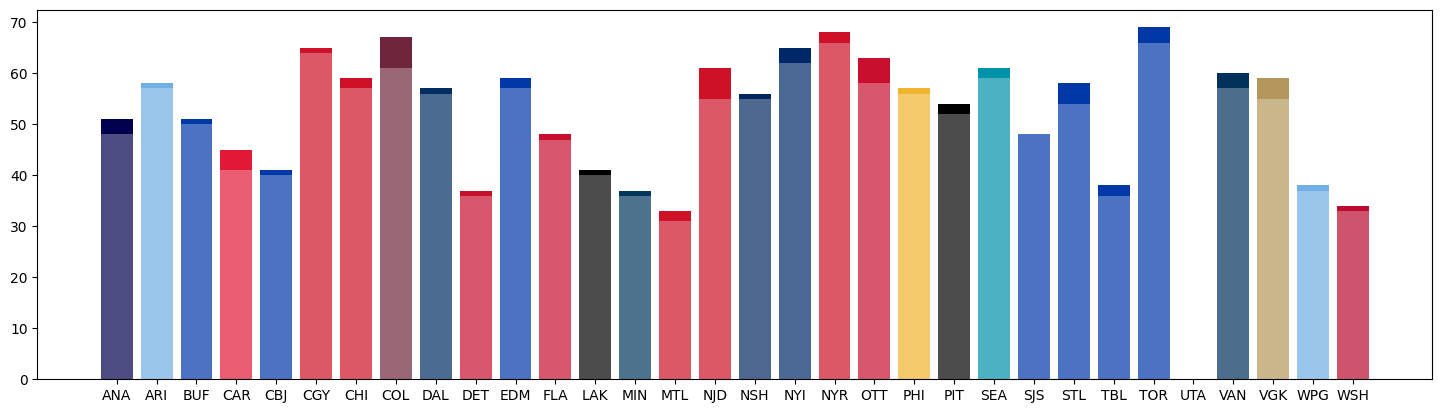

In [69]:
# rush_shots_by_team
fig, ax = plt.subplots()
ax.bar(rush_shots_by_team['abbrev'], rush_shots_by_team['count'], width=0.8, color=rush_shots_by_team['color1'], alpha=0.7)
ax.bar(rush_goals_by_team['abbrev'], rush_goals_by_team['count'], width=0.8, bottom=rush_shots_by_team['count'], color=rush_goals_by_team['color1'], alpha=1.0)
fig.set_figwidth(18)

#### Rebound goals

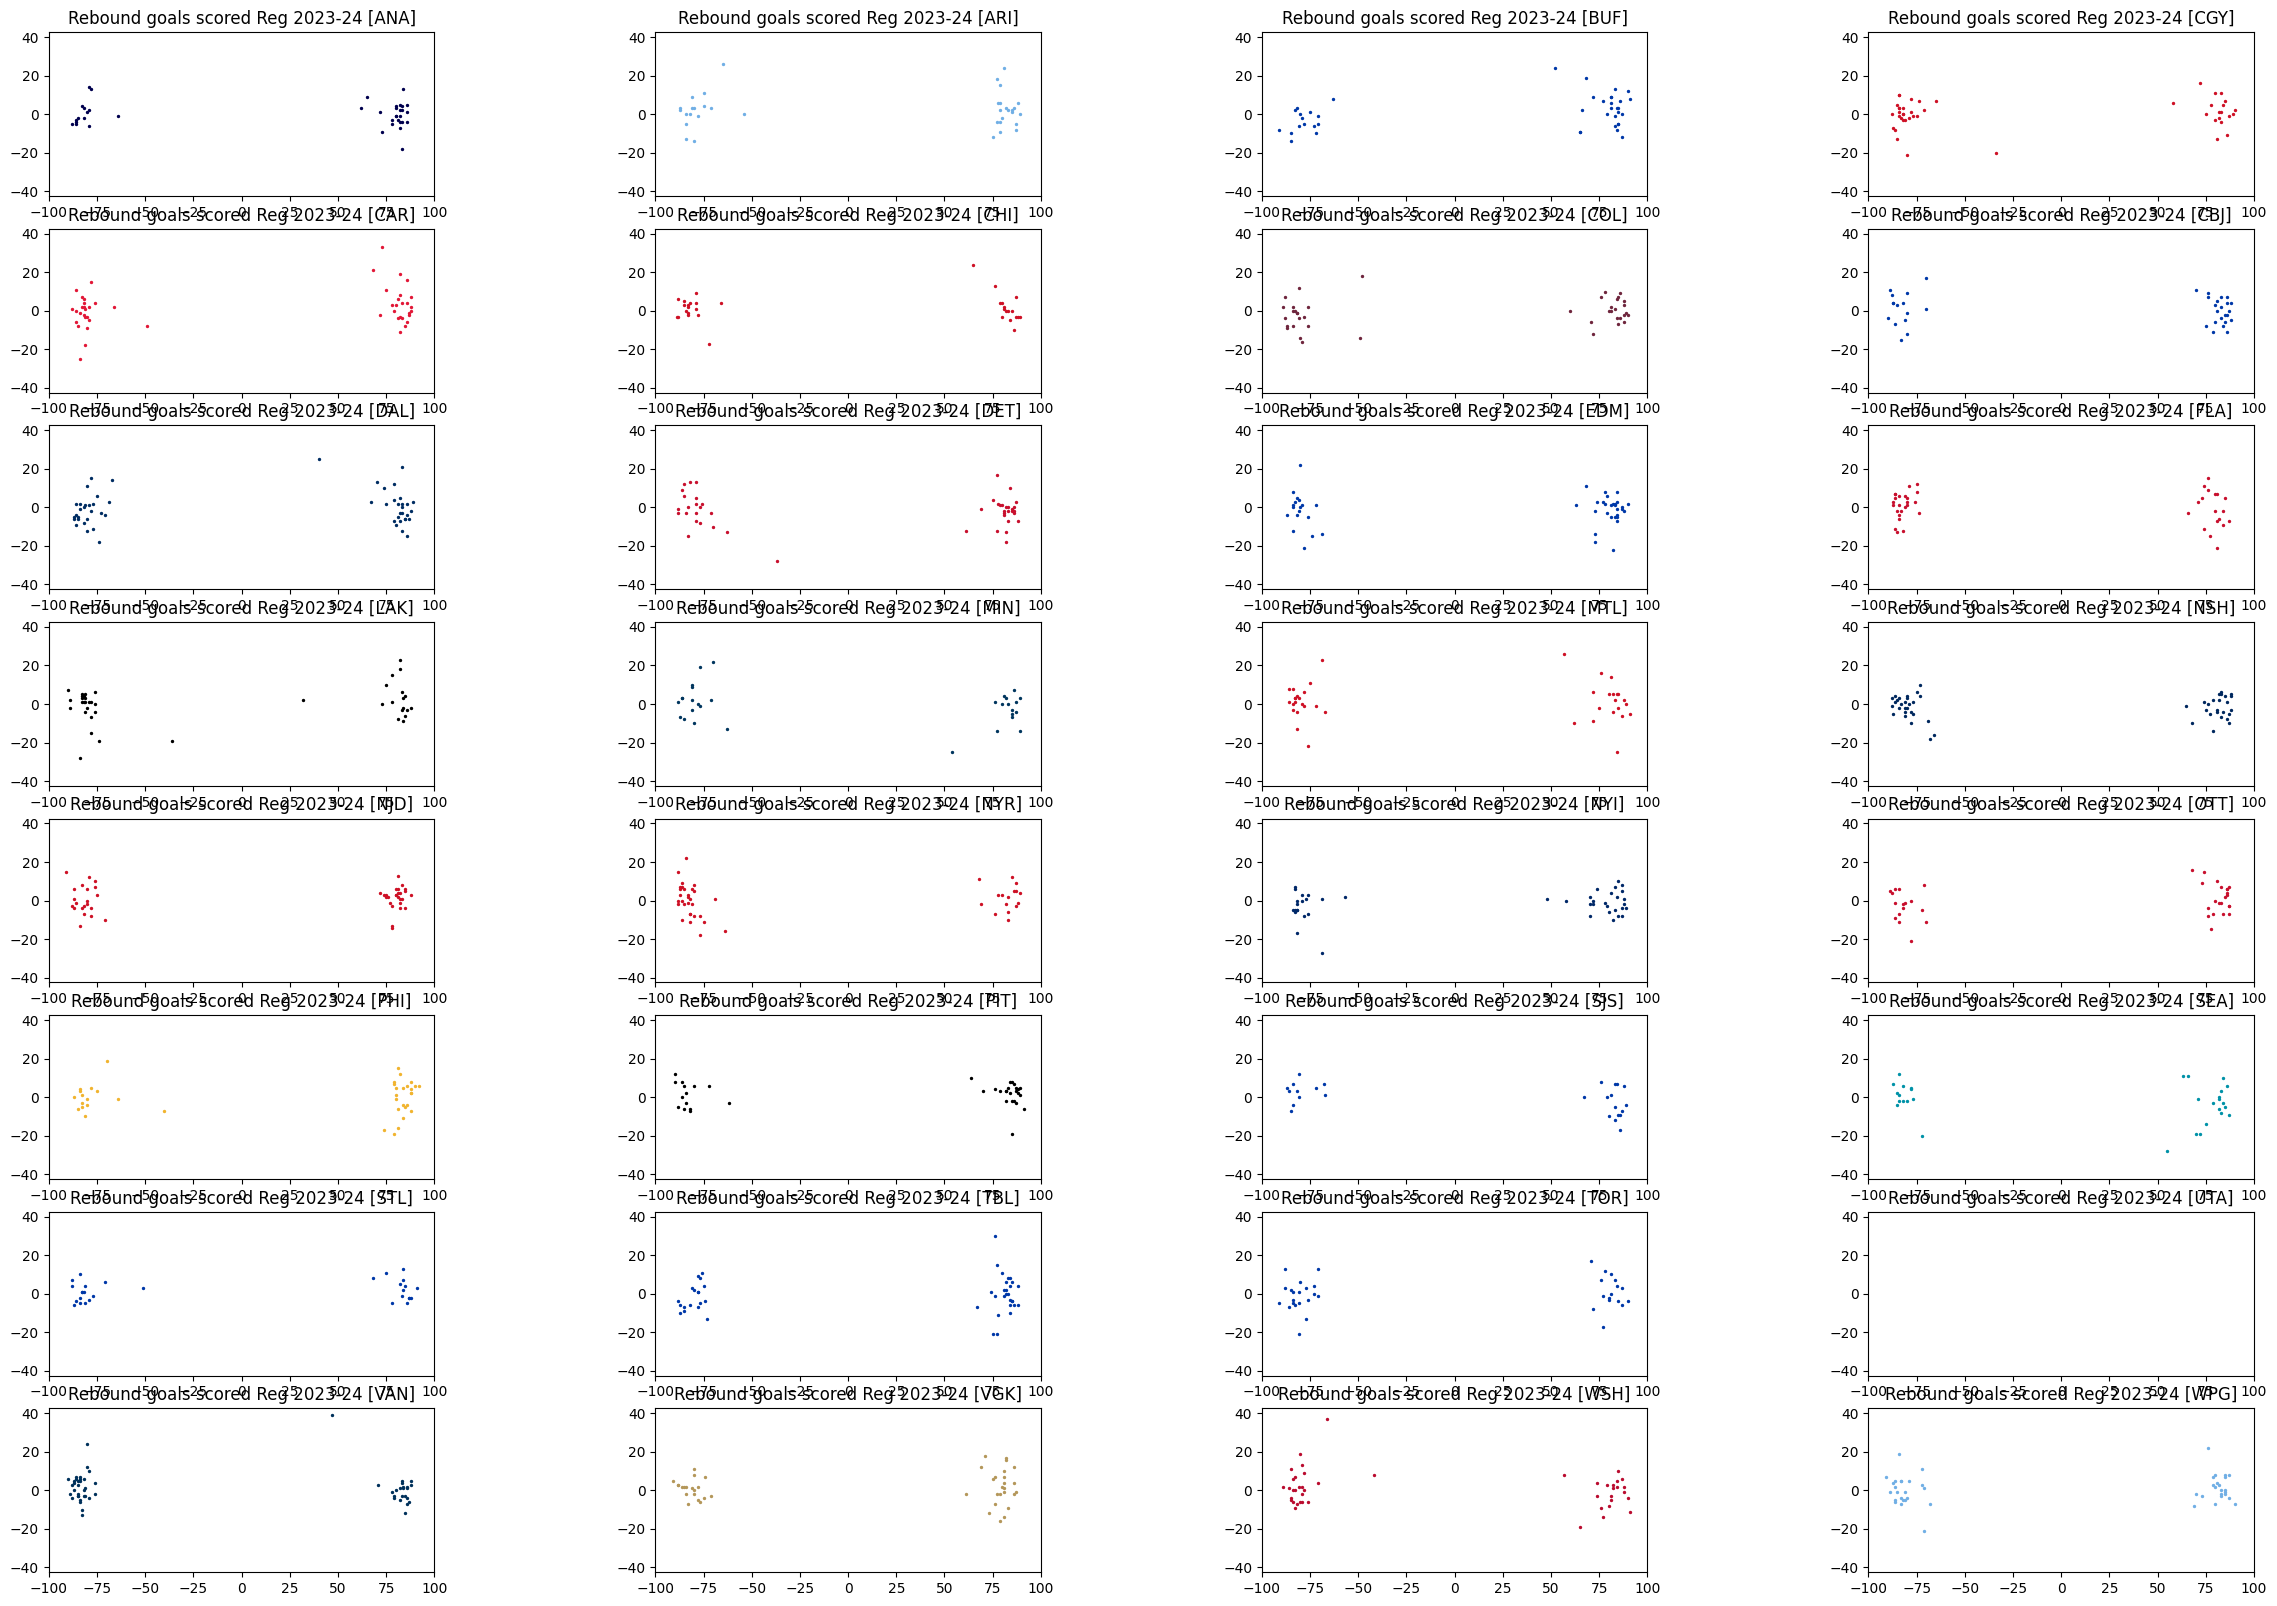

In [70]:
rebound_all = (
    plays
    .filter(pl.col('rebound') == 1)
    .filter(pl.col('season') == 20232024)
    .filter(pl.col('gameType') == 2)
)
fig, axes = draw_teams_goals(
    rebound_all.filter(pl.col('shot') == 1),
    "Rebound goals scored Reg 2023-24 [%s]",
    'goalByTeamId'
)

In [71]:
rebound_shots_by_team = get_counts_by_team(
    rebound_all
    .with_columns(shotOnly=pl.col('shot') - pl.col('goal'))
    .filter(pl.col('shotOnly') == 1)
)
rebound_goals_by_team = get_counts_by_team(rebound_all.filter(pl.col('goal') == 1))
# rebound_goals_by_team, rebound_shots_by_team

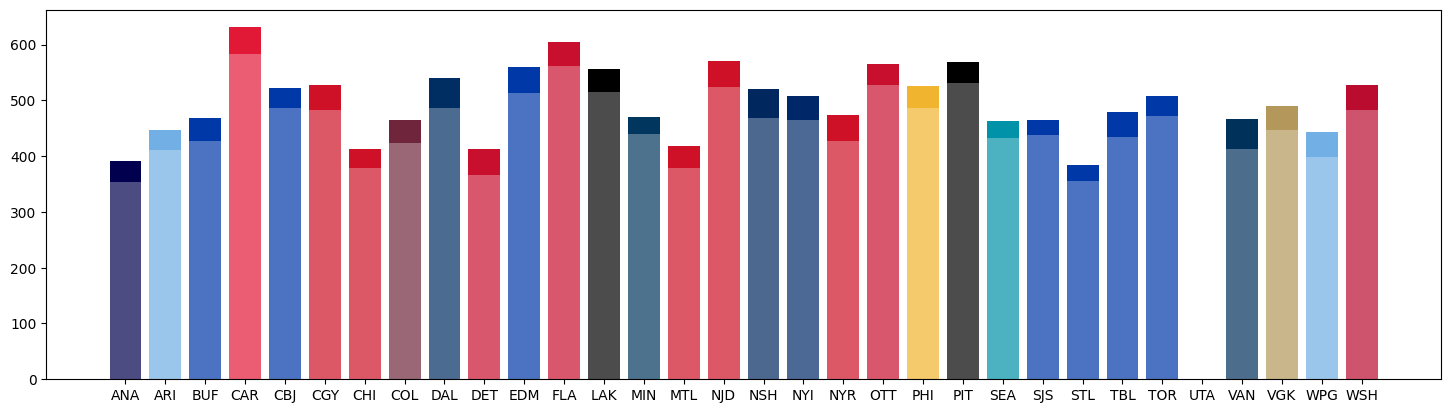

In [72]:
# rebound_shots_by_team
fig, ax = plt.subplots()
ax.bar(rebound_shots_by_team['abbrev'], rebound_shots_by_team['count'], width=0.8, color=rebound_shots_by_team['color1'], alpha=0.7)
ax.bar(rebound_goals_by_team['abbrev'], rebound_goals_by_team['count'], width=0.8, bottom=rebound_shots_by_team['count'], color=rebound_goals_by_team['color1'], alpha=1.0)
fig.set_figwidth(18)

# Modelling xG: Attempt 1

In [9]:
_play_example = plays.head(1).collect()
_play_example

gameId,eventId,period,periodType,timeRemaining,situationCode,typeCode,typeDescKey,sortOrder,homeTeamDefendingSide,assist1PlayerId,assist1PlayerTotal,assist2PlayerId,assist2PlayerTotal,awaySOG,awayScore,blockingPlayerId,committedByPlayerId,descKey,discreteClip,drawnByPlayerId,duration,eventOwnerTeamId,goalieInNetId,highlightClip,highlightClipFr,highlightClipSharingUrl,highlightClipSharingUrlFr,hitteePlayerId,hittingPlayerId,homeSOG,homeScore,losingPlayerId,playerId,reason,scoringPlayerId,scoringPlayerTotal,…,distFromNet,homeGf,awayGf,homeCf,awayCf,homeBlocked,awayBlocked,homeMiss,awayMiss,homeSog,awaySog,homeFf,awayFf,lastXCoord,lastYCoord,lastHomeShotXCoord,lastAwayShotXCoord,lastHomeShotYCoord,lastAwayShotYCoord,lastHomeShotAngDeg,lastAwayShotAngDeg,lastTimeRemainingSec,lastHomeShotTimeRemainingSec,lastAwayShotTimeRemainingSec,deltaTime,deltaTimeHomeShot,deltaTimeAwayShot,deltaAngDegHomeShot,deltaAngDegAwayShot,deltaXCoord,deltaYCoord,deltaDist,deltaDistShot,deltaTimeShot,rush,rebound,shotDeltaDistOverDeltaTime
i64,i64,i64,str,str,str,i64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,str,i64,i64,…,f64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,f64,i32,i32,f64
2022020320,8,1,"""REG""","""20:00""","""1551""",520,"""period-start""",8,"""left""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,1200,null,null,0,null,null,null,null,null,null,null,null,0.0001,0,0,null


In [10]:
print(list(_play_example.columns))

['gameId', 'eventId', 'period', 'periodType', 'timeRemaining', 'situationCode', 'typeCode', 'typeDescKey', 'sortOrder', 'homeTeamDefendingSide', 'assist1PlayerId', 'assist1PlayerTotal', 'assist2PlayerId', 'assist2PlayerTotal', 'awaySOG', 'awayScore', 'blockingPlayerId', 'committedByPlayerId', 'descKey', 'discreteClip', 'drawnByPlayerId', 'duration', 'eventOwnerTeamId', 'goalieInNetId', 'highlightClip', 'highlightClipFr', 'highlightClipSharingUrl', 'highlightClipSharingUrlFr', 'hitteePlayerId', 'hittingPlayerId', 'homeSOG', 'homeScore', 'losingPlayerId', 'playerId', 'reason', 'scoringPlayerId', 'scoringPlayerTotal', 'secondaryReason', 'shootingPlayerId', 'shotType', 'typeCode_right', 'winningPlayerId', 'xCoord', 'yCoord', 'zoneCode', 'homeTeamId', 'awayTeamId', 'gameType', 'season', 'homeNetXCoordEst', 'awayNetXCoordEst', 'eventBy', 'goal', 'shot', 'block', 'miss', 'homeEn', 'awayEn', 'homeSkt', 'awaySkt', 'timeRemainingSec', 'numOtPeriods', 'numRegPeriods', 'otLengthSec', 'timeSinceSta

In [11]:
import numpy as np
from typing import Iterable
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator

np.set_printoptions(suppress=True)

shot_attempts_counts = plays.filter(pl.col('shot') == 1).collect()['typeDescKey'].value_counts()
shot_attempts_counts

typeDescKey,count
str,u32
"""goal""",15029
"""blocked-shot""",78743
"""shot-on-goal""",133433
"""missed-shot""",63689


In [12]:
_, goals = shot_attempts_counts.row(by_predicate=pl.col('typeDescKey') == 'goal')
_, sogs = shot_attempts_counts.row(by_predicate=pl.col('typeDescKey') == 'shot-on-goal')
print(f"league wide SV: {sogs/(sogs + goals):3f}")

league wide SV: 0.898769


In [13]:
def to_camel_case(snake_str):
    capsd = "".join(x.capitalize() for x in snake_str.lower().split("-"))
    return f"{capsd[:1].lower()}{capsd[1:]}"

shots_table = (
    plays
    .filter(pl.col('shot') == 1)
    .filter(pl.col('typeDescKey') != 'blocked-shot')
    .with_columns(
        # relative to shooting team
        sktDiffRel=pl.when(is_event_by('home')).then(1).otherwise(-1) * (pl.col('homeSkt') - pl.col('awaySkt')),
        goalieDiffRel=pl.when(is_event_by('home')).then(1).otherwise(-1) * (
            pl.when(pl.col('homeEn')).then(0).otherwise(1) - pl.when(pl.col('awayEn')).then(0).otherwise(1)
        ),
        ffRel=pl.when(is_event_by('home')).then('homeFf').otherwise('awayFf'),
    )
    .with_columns(**{
        to_camel_case(shotType): pl.when(pl.col('shotType') == pl.lit(shotType)).then(1).otherwise(0)
        for shotType in SHOTTYPES.filter(pl.col('shotType').is_not_null()).collect()['shotType']
    })
)

In [69]:
from typing import Callable, Optional

def test_train(attributes: list[str], outcome: str, test_size=0.2, seed=111):
    X = shots_table.select(attributes).fill_nan(0).fill_null(0).collect().to_pandas()
    y = shots_table.select(outcome).collect().to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    return X_train, X_test, y_train, y_test

def draw_heatmap(matrix: np.matrix, xticks: list[str], yticks: list[str], title: str, tcolor: str = "w", manip: Optional[Callable] = None):
    manip = manip or (lambda x:x)
    fig, ax = plt.subplots()
    im = ax.imshow(np.abs(matrix), cmap="hot")
    # print(matrix)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(xticks)), labels=xticks,
                rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(yticks)), labels=yticks,
                rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(yticks)):
        for j in range(len(xticks)):
            text = ax.text(j, i, round(manip(matrix[i, j]), 2),
                        ha="center", va="center", color=tcolor)

    ax.set_title(title)

def eval_model(X_train: Iterable, X_test: Iterable, y_train: Iterable, y_test: Iterable, model: BaseEstimator):
    scaler = StandardScaler()
    fig, axes = plt.subplots(1, 1)
    def eval_set(X_t, y_t, ax, label):
        y_hat = model.predict_proba(scaler.fit_transform(X_t))
        val_log_loss = metrics.log_loss(y_t, y_hat[:,1])
        val_roc_auc = metrics.roc_auc_score(y_t, y_hat[:,1])
        fpr, tpr, _ = metrics.roc_curve(y_t,  y_hat[:,1])
        ax.plot(fpr, tpr ,label=f"auc={label}[{val_roc_auc:4}]")
        print(f'The log loss of our model on the {label} set is : {val_log_loss:4f}')
        print(f'The ROC AUC of our model on the {label} set is : {val_roc_auc:4f}')
    eval_set(X_train, y_train, axes, 'train')
    eval_set(X_test, y_test, axes, 'test')

    y_hat_test = model.predict(scaler.fit_transform(X_test))
    cnf_mtrx = metrics.confusion_matrix(y_true=y_test, y_pred=y_hat_test)
    draw_heatmap(
        cnf_mtrx,
        xticks=['goal_hat = 0', 'goal_hat = 1'], 
        yticks=['goal = 0', 'goal = 1'], 
        title="Confusion Matrix of outcomes",
        tcolor="red"
    )

    axes.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
    axes.set_xlabel('False Positive Rate')
    axes.set_ylabel('True Positive Rate')
    axes.legend(loc=4)

## Random Forests

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [71]:
def get_rf_model(X_train: Iterable, y_train: Iterable, outcome: str):
    scaler = StandardScaler()
    clf1 = RandomForestClassifier()
    model = clf1.fit(scaler.fit_transform(X_train), y_train)
    return model


In [74]:
X_train, X_test, y_train, y_test = test_train(attributes=['distFromNet', 'deltaTime', 'deltaTimeShot', 'sktDiffRel', 'goalieDiffRel'], outcome='goal')
naive_rf_model = get_rf_model(X_train, y_train.ravel(), 'goal')

The log loss of our model on the train set is : 0.080723
The ROC AUC of our model on the train set is : 0.990787
The log loss of our model on the test set is : 0.613667
The ROC AUC of our model on the test set is : 0.661446


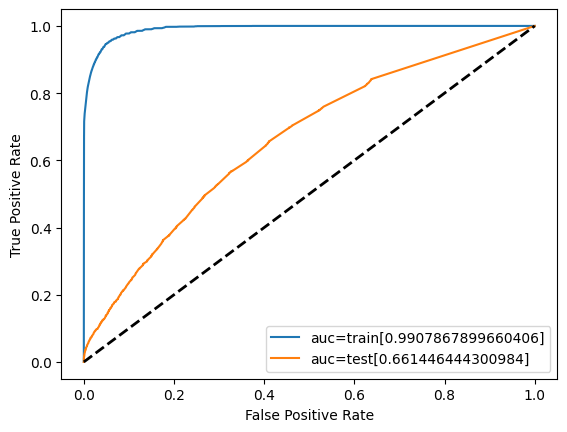

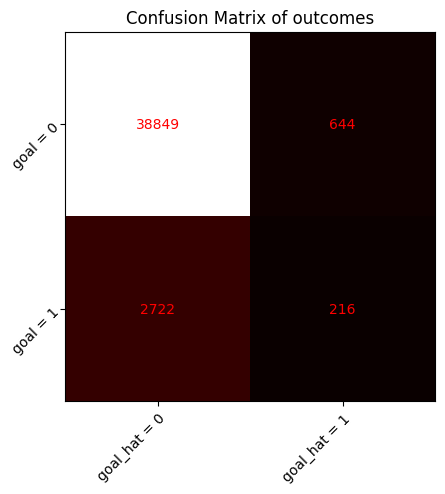

In [75]:
eval_model(X_train, X_test, y_train, y_test, naive_rf_model)

In [80]:
X_train, X_test, y_train, y_test = test_train(attributes=[
    'distFromNet', 'goalieDiffRel', 'angDeg', 
    'tipIn', 'deflected', 'wrist', 'snap', 'slap', 
    # 'rebound', 'poke', 'cradle', 'betweenLegs', 'wrapAround',
], outcome='goal')
naive_rf_model = get_rf_model(X_train, y_train.ravel(), 'goal')

The log loss of our model on the train set is : 0.195005
The ROC AUC of our model on the train set is : 0.835790
The log loss of our model on the test set is : 0.340548
The ROC AUC of our model on the test set is : 0.719301


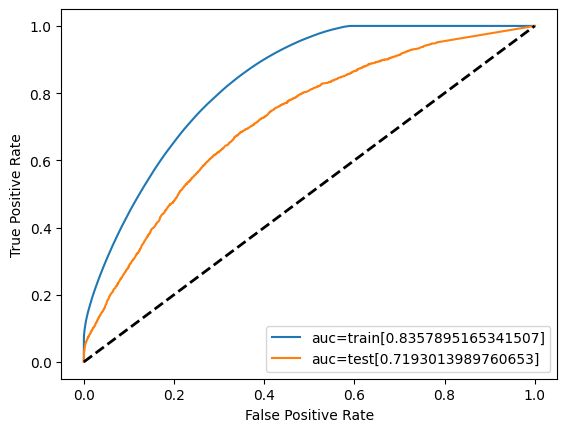

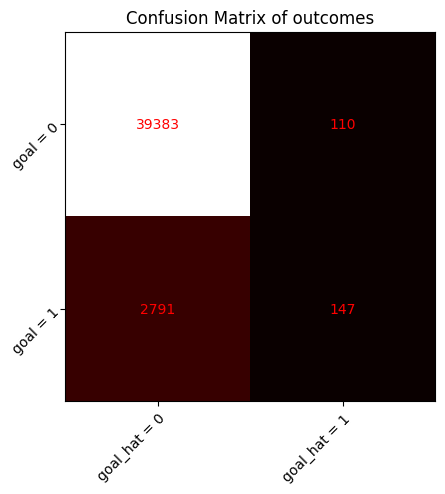

In [81]:
eval_model(X_train, X_test, y_train, y_test, naive_rf_model)

## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

In [83]:
def get_logreg_model(X_train: Iterable, y_train: Iterable, max_iter=10000):
    scaler = StandardScaler()
    clf1 = LogisticRegression(max_iter=max_iter)
    model = clf1.fit(scaler.fit_transform(X_train), y_train.ravel())
    return model

def eval_logreg_model(X_train: pl.DataFrame, X_test: pl.DataFrame, y_train: Iterable, y_test: Iterable, model: BaseEstimator):
    eval_model(X_train, X_test, y_train, y_test, model)
    scaler = StandardScaler()
    class_report = metrics.classification_report(
        y_pred=model.predict(scaler.fit_transform(X_test)),
        y_true=y_test
    )
    print(class_report)
    print(pl.DataFrame({
        'attr': X_train.columns,
        'coef': model.coef_[0],
        'abscoef': np.abs(model.coef_[0])
    }).sort('abscoef', descending=True).select('attr', 'coef'))
    print(f"Score: {model.score}")
    

The log loss of our model on the train set is : 0.239263
The ROC AUC of our model on the train set is : 0.706465
The log loss of our model on the test set is : 0.235014
The ROC AUC of our model on the test set is : 0.702402
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     39493
           1       0.80      0.03      0.05      2938

    accuracy                           0.93     42431
   macro avg       0.87      0.51      0.51     42431
weighted avg       0.92      0.93      0.90     42431

shape: (5, 2)
┌───────────────┬───────────┐
│ attr          ┆ coef      │
│ ---           ┆ ---       │
│ str           ┆ f64       │
╞═══════════════╪═══════════╡
│ distFromNet   ┆ -0.867762 │
│ goalieDiffRel ┆ -0.608221 │
│ sktDiffRel    ┆ 0.107941  │
│ deltaTime     ┆ -0.062627 │
│ deltaTimeShot ┆ 0.016884  │
└───────────────┴───────────┘
Score: <bound method ClassifierMixin.score of LogisticRegression(max_iter=10000)>


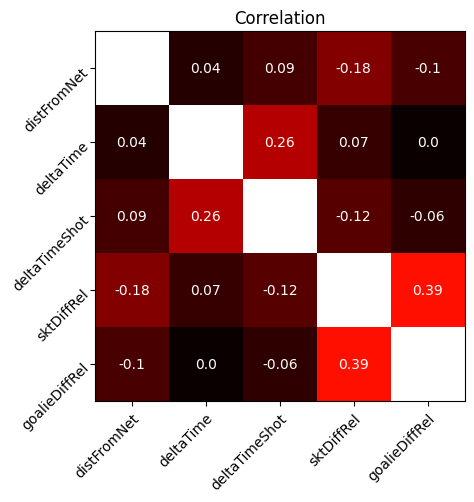

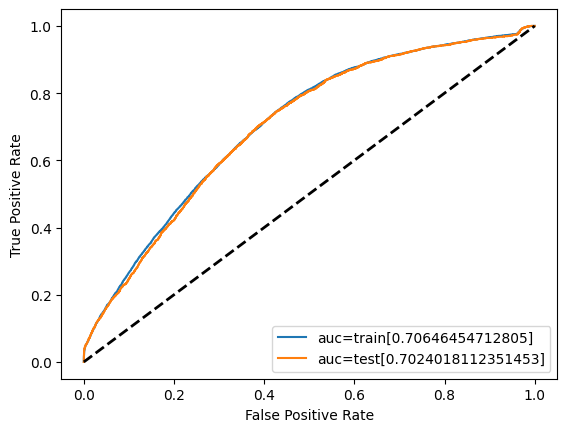

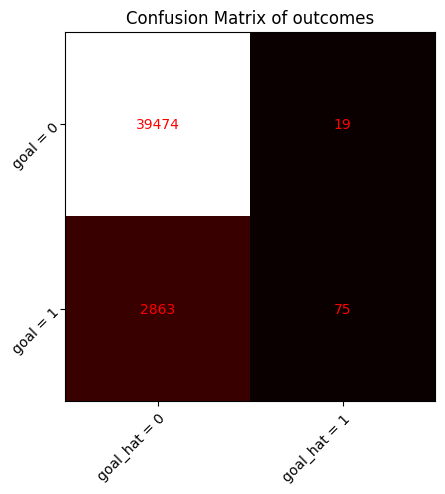

In [84]:
X_train, X_test, y_train, y_test = test_train(attributes=['distFromNet', 'deltaTime', 'deltaTimeShot', 'sktDiffRel', 'goalieDiffRel'], outcome='goal')
xcorr = X_test.corr()
draw_heatmap(xcorr.to_numpy(), xcorr.columns, xcorr.columns, "Correlation")
model = get_logreg_model(X_train, y_train)
eval_logreg_model(X_train, X_test, y_train, y_test, model)

The log loss of our model on the train set is : 0.236683
The ROC AUC of our model on the train set is : 0.722529
The log loss of our model on the test set is : 0.232712
The ROC AUC of our model on the test set is : 0.718348
shape: (5, 2)
┌───────────────┬───────────┐
│ attr          ┆ coef      │
│ ---           ┆ ---       │
│ str           ┆ f64       │
╞═══════════════╪═══════════╡
│ distFromNet   ┆ -0.919312 │
│ goalieDiffRel ┆ -0.601491 │
│ angDeg        ┆ -0.277833 │
│ sktDiffRel    ┆ 0.093764  │
│ deltaTime     ┆ -0.05723  │
└───────────────┴───────────┘
Score: <bound method ClassifierMixin.score of LogisticRegression(max_iter=10000)>


TypeError: missing a required argument: 'y_pred'

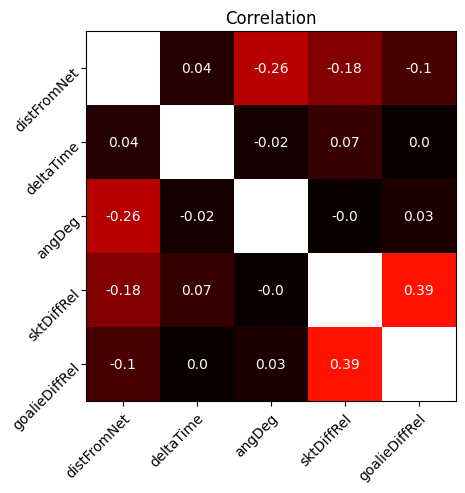

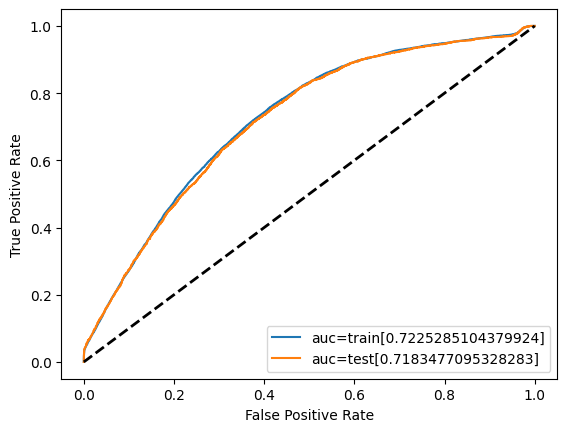

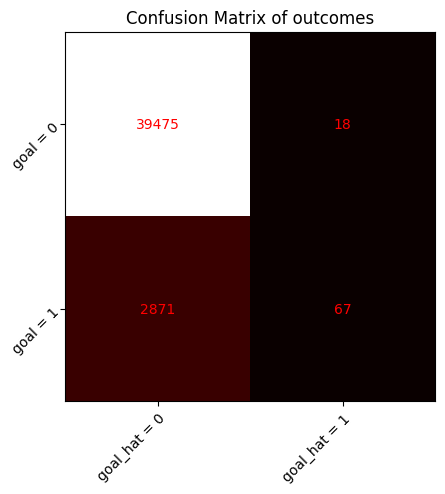

In [ ]:
X_train, X_test, y_train, y_test = test_train(attributes=['distFromNet', 'deltaTime', 'angDeg', 'sktDiffRel', 'goalieDiffRel'], outcome='goal')
model = get_logreg_model(X_train, y_train)
xcorr = X_test.corr()
draw_heatmap(xcorr.to_numpy(), xcorr.columns, xcorr.columns, "Correlation")
eval_logreg_model(X_train, X_test, y_train, y_test, model)

The log loss of our model on the train set is : 0.236600
The ROC AUC of our model on the train set is : 0.723070
The log loss of our model on the test set is : 0.232534
The ROC AUC of our model on the test set is : 0.719062
Confusion matrix: 
[[39475    18]
 [ 2870    68]]
shape: (8, 2)
┌────────────────────────────┬───────────┐
│ attr                       ┆ coef      │
│ ---                        ┆ ---       │
│ str                        ┆ f64       │
╞════════════════════════════╪═══════════╡
│ distFromNet                ┆ -0.901824 │
│ goalieDiffRel              ┆ -0.599142 │
│ angDeg                     ┆ -0.279519 │
│ sktDiffRel                 ┆ 0.090955  │
│ rebound                    ┆ 0.044063  │
│ deltaTime                  ┆ -0.037299 │
│ rush                       ┆ -0.014299 │
│ shotDeltaDistOverDeltaTime ┆ 0.008513  │
└────────────────────────────┴───────────┘
Score: <bound method ClassifierMixin.score of LogisticRegression(max_iter=10000)>


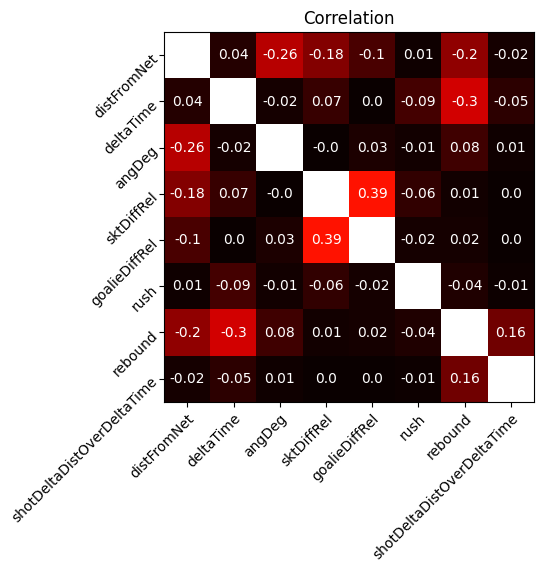

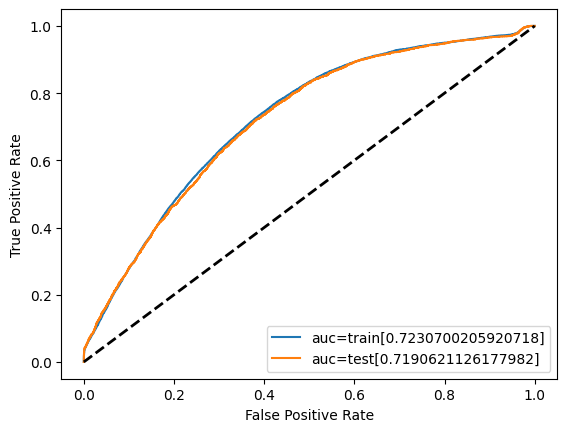

In [52]:
attributes = [
    'distFromNet', 'deltaTime', 'angDeg', 'sktDiffRel', 'goalieDiffRel',
    'rush', 'rebound', 'shotDeltaDistOverDeltaTime'
]
X_train, X_test, y_train, y_test = test_train(attributes=attributes, outcome='goal')
xcorr = X_test.corr()
draw_heatmap(xcorr.to_numpy(), xcorr.columns, xcorr.columns, "Correlation")
model = get_logreg_model(X_train, y_train)
eval_logreg_model(X_train, X_test, y_train, y_test, model)

The log loss of our model on the train set is : 0.234834
The ROC AUC of our model on the train set is : 0.734696
The log loss of our model on the test set is : 0.230724
The ROC AUC of our model on the test set is : 0.730287
Confusion matrix: 
[[39474    19]
 [ 2867    71]]
shape: (8, 2)
┌───────────────┬───────────┐
│ attr          ┆ coef      │
│ ---           ┆ ---       │
│ str           ┆ f64       │
╞═══════════════╪═══════════╡
│ distFromNet   ┆ -1.129398 │
│ goalieDiffRel ┆ -0.601925 │
│ angDeg        ┆ -0.31833  │
│ snap          ┆ 0.258554  │
│ slap          ┆ 0.220418  │
│ wrist         ┆ 0.182532  │
│ tipIn         ┆ -0.041627 │
│ deflected     ┆ -0.026714 │
└───────────────┴───────────┘
Score: <bound method ClassifierMixin.score of LogisticRegression(max_iter=10000)>


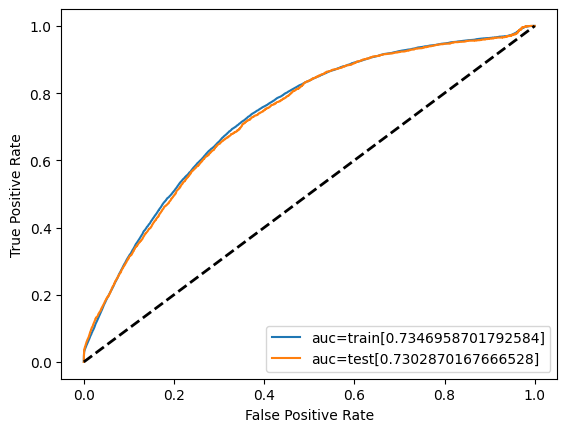

In [141]:
attributes = [
    'distFromNet', 'goalieDiffRel', 'angDeg', 
    'tipIn', 'deflected', 'wrist', 'snap', 'slap', 
    # 'rebound', 'poke', 'cradle', 'betweenLegs', 'wrapAround',
]
X_train, X_test, y_train, y_test = test_train(attributes=attributes, outcome='goal')
model = get_logreg_model(X_train, y_train)
eval_logreg_model(X_train, X_test, y_train, y_test, model)

# Transforming Data again

Maybe the FF of the teams leading up to the game will be more useful

In [208]:
fenwick_table = GAMES.select(['id', 'startTimeUTC']).with_columns(**{
    f"{abbrev.lower()}Ff": pl.lit(0)
    for abbrev in team_id_abbrev.collect()['abbrev']
}).sort('startTimeUTC', descending=False)
fenwick_table.collect()

id,startTimeUTC,anaFf,ariFf,bufFf,cgyFf,carFf,chiFf,colFf,cbjFf,dalFf,detFf,edmFf,flaFf,lakFf,minFf,mtlFf,nshFf,njdFf,nyrFf,nyiFf,ottFf,phiFf,pitFf,sjsFf,seaFf,stlFf,tblFf,torFf,utaFf,vanFf,vgkFf,wshFf,wpgFf
i64,"datetime[μs, UTC]",i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
2022020365,2022-12-02 00:00:00 UTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022020366,2022-12-02 00:00:00 UTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022020367,2022-12-02 00:00:00 UTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022020368,2022-12-02 00:00:00 UTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022020369,2022-12-02 01:00:00 UTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022020370,2022-12-02 01:00:00 UTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022020371,2022-12-02 01:30:00 UTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022020372,2022-12-02 02:00:00 UTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022020373,2022-12-02 03:00:00 UTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
